In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [72]:
# cd
import os
path = os.getcwd()
print(path)

/Users/kanazawaatsuya/imp/MQ2007/RankNet


In [73]:
from ptranking.data.data_utils import LTRDataset, SPLIT_TYPE
data_id = 'MQ2007_Super'
#MQ2007内にあるもの
s1 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S1.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)
s2 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S2.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)
s3 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S3.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)
s4 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S4.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)
s5 = LTRDataset(SPLIT_TYPE.Train, data_id=data_id, file='S5.txt', batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)

In [74]:
layers = [nn.Linear(46, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 1)]

In [75]:
class RankNet(nn.Module):
    def __init__(self, layers):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(*layers)
        
    def forward(self, batch_ranking, label):
        batch_pred = self.model(batch_ranking) # [1, 40, 1]
        batch_sij = torch.squeeze(batch_pred, 0) - torch.squeeze(batch_pred, 2) # [40, 40]
        batch_pij = 1.0 / (1.0 + torch.exp(-batch_sij)) # [40, 40]

        label_dim = torch.squeeze(label)
        label_diffs = torch.unsqueeze(label_dim, 1) - label # [40,40]
        batch_Sij = torch.clamp(label_diffs, -1, 1)
        l_pij = 0.5 * (1.0 + batch_Sij)

        batch_loss = F.binary_cross_entropy(input=torch.triu(batch_pij, diagonal=1), target=torch.triu(l_pij, diagonal=1), reduction='mean')    
        
        return batch_loss
    
    def predict(self, x):
        return self.model(x)

In [76]:
# ndcg
def DCG(sorted_labels, cutoff):
    denoms = torch.log2(torch.arange(2, cutoff+2))
    nums = torch.pow(2, sorted_labels[0:cutoff])-1
    dcg = sum(nums / denoms)
    return dcg

def nDCG(ideal, pred, k):
    dcg_f = DCG(pred, k)
    dcg = DCG(ideal, k)
    nDCG = dcg_f / dcg
    return nDCG

def compute_ndcg(model, score, label, cutoff):
    batch_pred = model.predict(score)
    idx = torch.argsort(torch.squeeze(batch_pred),descending = True)
    pred_sorted_labels = torch.squeeze(label)[idx]
    ndcg = torch.nan_to_num(nDCG(torch.squeeze(label), pred_sorted_labels, cutoff))
    
    return ndcg

In [77]:
def testing(model, data, cutoff):
    with torch.no_grad():
        ndcg_sum = 0
        for _,batch_ranking,label in data:
        #computes ndcg
            ndcg = compute_ndcg(model,batch_ranking,label,cutoff)
            ndcg_sum += ndcg  
    ndcg_sum /= len(data)
    return(ndcg_sum)

In [78]:
def training_loop2(n_epochs,optimizer,model,train):
    
    ndcg1=[]
    ndcg5=[]
    
    # モデルの訓練
    for epoch in range(1, n_epochs + 1):
        
        # クエリごとの訓練
        batch_loss = 0
        batch_ndcg1 = 0
        batch_ndcg5 = 0
        for _,batch_ranking,label in train:
            batch_loss += model.forward(batch_ranking=batch_ranking, label=label)
            #print(compute_ndcg(batch_ranking,label,5))
            batch_ndcg1 += compute_ndcg(model,batch_ranking,label,1)
            batch_ndcg5 += compute_ndcg(model,batch_ranking,label,5)
                    
        fold_loss_mean = batch_loss / len(train)
        fold_ndcg1_mean = batch_ndcg1 / len(train)
        fold_ndcg5_mean = batch_ndcg5 / len(train)
        
        ndcg1.append(fold_ndcg1_mean)
        ndcg5.append(fold_ndcg5_mean)
        
        if epoch == 1 or epoch % 100 ==0:
            print('epoch:{0}, loss:{1}, ndcg@1:{2}, ndcg@5:{3}'.format(epoch, fold_loss_mean, fold_ndcg1_mean, fold_ndcg5_mean))
            
        #print('epoch:{0}, loss:{1}, ndcg@1:{2}, ndcg@5:{3}'.format(epoch, fold_loss_mean, fold_ndcg1_mean, fold_ndcg5_mean))
        
        optimizer.zero_grad()
        fold_loss_mean.backward()
        optimizer.step()
    
    return [ndcg1, ndcg5]

In [79]:
model = RankNet(layers)

In [80]:
# 学習前のパラメータの保存
torch.save(model.state_dict(), 'weight.pth')

# 学習前のパラメータの読み込みを行うとき
param = torch.load('weight.pth')
model.load_state_dict(param)

<All keys matched successfully>

In [81]:
param

OrderedDict([('model.0.weight',
              tensor([[ 0.0989, -0.0883, -0.0804,  ...,  0.0856, -0.1083, -0.1411],
                      [-0.0916,  0.0821, -0.0514,  ...,  0.0797,  0.1459,  0.0109],
                      [ 0.0474, -0.1113, -0.0173,  ...,  0.0726,  0.0758,  0.0896],
                      ...,
                      [-0.1170, -0.1052, -0.0139,  ..., -0.0126, -0.0725,  0.1473],
                      [ 0.0491,  0.0366, -0.1125,  ...,  0.0743,  0.0666, -0.1219],
                      [ 0.0480,  0.0849, -0.0153,  ...,  0.0871, -0.1463, -0.0788]])),
             ('model.0.bias',
              tensor([ 0.0538, -0.0916,  0.0502,  0.1354, -0.1473,  0.0510,  0.0650, -0.0345,
                      -0.1309,  0.0763, -0.0390, -0.0491,  0.0348,  0.0513,  0.0073, -0.0357,
                      -0.0615, -0.0471, -0.0267,  0.0048,  0.0366, -0.1026,  0.0090, -0.0021,
                       0.1274,  0.1128,  0.1209, -0.0042,  0.1243, -0.1300, -0.1397,  0.0698,
                      -0.075

In [82]:
data_list = [s1,s2,s3,s4,s5]

In [83]:
# 平均をとるという実験
train_fold_ndcg1=[]
train_fold_ndcg5=[]

test_fold_ndcg1=[]
test_fold_ndcg5=[]

for i in range(5):

    print("fold :", i+1)

    # 学習前のモデルを使う
    param = torch.load('weight.pth')
    #print(param)
    model.load_state_dict(param)
    
    # 学習を行う
    ndcg1, ndcg5 = training_loop2(
        n_epochs = 1000,
        optimizer = torch.optim.SGD(model.parameters(),lr = 0.01),
        model = model,
        train = data_list[0]+data_list[1],
        )

    # テスト
    test_ndcg1=testing(model, data_list[4], 1)
    test_ndcg5=testing(model, data_list[4], 5)

    print(test_ndcg1)
    print(test_ndcg5)

    # リストに追加
    train_fold_ndcg1.append(ndcg1)
    train_fold_ndcg5.append(ndcg5)
    
    test_fold_ndcg1.append(test_ndcg1)
    test_fold_ndcg5.append(test_ndcg5)
    
    data_list.insert(0,data_list.pop())


fold : 1
epoch:1, loss:0.33815905451774597, ndcg@1:0.15240907669067383, ndcg@5:0.18355251848697662
epoch:100, loss:0.3381434381008148, ndcg@1:0.1637168526649475, ndcg@5:0.1935797780752182
epoch:200, loss:0.33812808990478516, ndcg@1:0.17453300952911377, ndcg@5:0.2039499133825302
epoch:300, loss:0.33811303973197937, ndcg@1:0.18239928781986237, ndcg@5:0.21286024153232574
epoch:400, loss:0.33809787034988403, ndcg@1:0.19419868290424347, ndcg@5:0.2236655205488205
epoch:500, loss:0.33808261156082153, ndcg@1:0.206489697098732, ndcg@5:0.23424586653709412
epoch:600, loss:0.33806705474853516, ndcg@1:0.21288101375102997, ndcg@5:0.24224111437797546
epoch:700, loss:0.3380517363548279, ndcg@1:0.22615531086921692, ndcg@5:0.25193220376968384
epoch:800, loss:0.33803626894950867, ndcg@1:0.2330382764339447, ndcg@5:0.25951194763183594
epoch:900, loss:0.33802101016044617, ndcg@1:0.23549652099609375, ndcg@5:0.26525336503982544
epoch:1000, loss:0.3380058705806732, ndcg@1:0.24336276948451996, ndcg@5:0.26758673

In [23]:
type(train_fold_ndcg1)

In [24]:
data_list

[5, 1, 2, 3, 4]

In [ ]:
1+1

In [20]:
ndcg1, ndcg5 = training_loop2(
    n_epochs = 1000,
    optimizer = torch.optim.SGD(local_model1.parameters(),lr = 0.01),
    model = local_model1,
    train = first,
    )

epoch:1, loss:0.3381125032901764, ndcg@1:0.18780721724033356, ndcg@5:0.20724892616271973
epoch:100, loss:0.3381009101867676, ndcg@1:0.1976400762796402, ndcg@5:0.2185223400592804
epoch:200, loss:0.33808955550193787, ndcg@1:0.19960665702819824, ndcg@5:0.2267599254846573
epoch:300, loss:0.3380783498287201, ndcg@1:0.20255650579929352, ndcg@5:0.23344945907592773
epoch:400, loss:0.33806735277175903, ndcg@1:0.20255650579929352, ndcg@5:0.24084605276584625
epoch:500, loss:0.3380568325519562, ndcg@1:0.2055063545703888, ndcg@5:0.2501484453678131
epoch:600, loss:0.33804628252983093, ndcg@1:0.21730579435825348, ndcg@5:0.25559723377227783
epoch:700, loss:0.33803591132164, ndcg@1:0.2300885021686554, ndcg@5:0.26056739687919617
epoch:800, loss:0.33802536129951477, ndcg@1:0.23992134630680084, ndcg@5:0.2649264335632324
epoch:900, loss:0.33801499009132385, ndcg@1:0.24287119507789612, ndcg@5:0.27128440141677856
epoch:1000, loss:0.33800452947616577, ndcg@1:0.24483777582645416, ndcg@5:0.2751844823360443


In [21]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

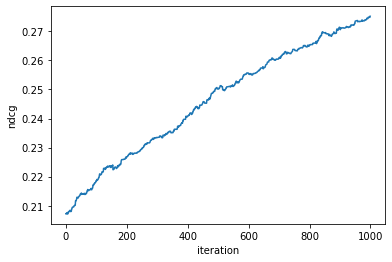

In [22]:
plt.plot(range(1000), ndcg5)
plt.ylabel("ndcg")
plt.xlabel("iteration")

second model

In [44]:
local_model2 = combined_model

In [45]:
second = s2

In [46]:
ndcg1_2, ndcg5_2 = training_loop2(
    n_epochs = 1000,
    optimizer = torch.optim.SGD(local_model2.parameters(),lr = 0.01),
    model = local_model2,
    train = second,
    )

epoch:1, loss:0.338033527135849, ndcg@1:0.2595870792865753, ndcg@5:0.24985063076019287
epoch:100, loss:0.3380052149295807, ndcg@1:0.2625369131565094, ndcg@5:0.256151020526886
epoch:200, loss:0.3379767835140228, ndcg@1:0.2625369131565094, ndcg@5:0.26785510778427124
epoch:300, loss:0.33794859051704407, ndcg@1:0.2753196060657501, ndcg@5:0.27607807517051697
epoch:400, loss:0.33792027831077576, ndcg@1:0.2792527675628662, ndcg@5:0.2813507914543152
epoch:500, loss:0.3378920257091522, ndcg@1:0.2822026312351227, ndcg@5:0.2904312312602997
epoch:600, loss:0.337863951921463, ndcg@1:0.29596859216690063, ndcg@5:0.3013566732406616
epoch:700, loss:0.33783581852912903, ndcg@1:0.3067847192287445, ndcg@5:0.31060218811035156
epoch:800, loss:0.33780765533447266, ndcg@1:0.3195674419403076, ndcg@5:0.32086077332496643
epoch:900, loss:0.3377794921398163, ndcg@1:0.32940027117729187, ndcg@5:0.3273599147796631
epoch:1000, loss:0.33775120973587036, ndcg@1:0.3372665345668793, ndcg@5:0.33439940214157104


Text(0.5, 0, 'iteration')

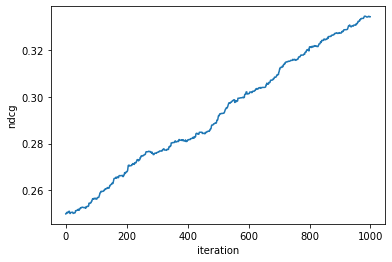

In [47]:
plt.plot(range(1000), ndcg5_2)
plt.ylabel("ndcg")
plt.xlabel("iteration")

Averaging Model Updates

In [48]:
from collections import OrderedDict

In [49]:
for param1 in local_model1.parameters():
    print(param1)

Parameter containing:
tensor([[-0.1003,  0.0039,  0.0886,  ..., -0.0470, -0.0589, -0.0376],
        [-0.0780,  0.1047,  0.0127,  ..., -0.0129, -0.0688, -0.0642],
        [-0.1106,  0.1291,  0.0738,  ..., -0.0477, -0.0226,  0.0282],
        ...,
        [-0.0735,  0.0641, -0.0651,  ..., -0.0780, -0.1289, -0.0414],
        [ 0.0024,  0.0181,  0.1459,  ..., -0.0802,  0.1009, -0.1419],
        [-0.1110,  0.0600, -0.0325,  ..., -0.0030, -0.0187, -0.1386]],
       requires_grad=True)
Parameter containing:
tensor([ 1.6475e-02,  1.1736e-01, -1.3395e-01, -1.1428e-01, -1.6961e-02,
        -1.4308e-01, -4.7777e-02,  8.8858e-02, -5.0016e-02,  5.7176e-04,
         1.1619e-01,  2.3700e-02,  5.2950e-02,  1.1244e-01,  1.2122e-01,
         3.4226e-02, -1.0279e-01, -1.1758e-01,  1.0573e-01,  9.1140e-02,
         1.0697e-02,  9.5113e-03, -9.3428e-05, -1.4628e-01,  7.8013e-02,
        -8.8653e-02, -1.3775e-03, -4.3461e-02,  5.5251e-02, -4.3901e-02,
        -6.0737e-02, -6.7563e-02, -4.0529e-04,  5.1932e-0

In [50]:
for param2 in local_model2.parameters():
    print(param2)

Parameter containing:
tensor([[ 0.0282,  0.0183, -0.0827,  ..., -0.0664, -0.0344,  0.0738],
        [ 0.0409,  0.0939, -0.1441,  ...,  0.1057, -0.1098,  0.1311],
        [ 0.0065, -0.1105,  0.1383,  ...,  0.1362,  0.1084,  0.0111],
        ...,
        [-0.0512, -0.0844,  0.1053,  ...,  0.0799,  0.0574,  0.0743],
        [ 0.1102, -0.1263,  0.0739,  ..., -0.1154,  0.0933, -0.0164],
        [-0.0297, -0.1027,  0.0549,  ...,  0.0925, -0.0375, -0.0139]],
       requires_grad=True)
Parameter containing:
tensor([-0.1154,  0.0436, -0.0347,  0.1376,  0.1139,  0.1349, -0.0237, -0.1215,
        -0.1310, -0.1203,  0.0769, -0.0710, -0.0530, -0.0655,  0.0019,  0.0295,
        -0.0721, -0.1290,  0.1042,  0.1380,  0.0406, -0.0372,  0.1179, -0.0008,
         0.1389, -0.1089, -0.0894,  0.0829,  0.0933,  0.0360,  0.0057, -0.0670,
        -0.0820, -0.1388, -0.0514, -0.1321,  0.0126,  0.0709, -0.0037, -0.0483,
         0.0782,  0.0955, -0.0019,  0.0605,  0.0969,  0.0288,  0.0672,  0.0094,
         0.0579

In [51]:
model1_updates = local_model1.state_dict()
#model1_updates

In [52]:
model2_updates = local_model2.state_dict()
#model2_updates

In [53]:
avg_updates = OrderedDict()

In [54]:
avg_updates["model.0.weight"] = (
    model1_updates["model.0.weight"] + model2_updates["model.0.weight"]
) / 2

avg_updates["model.0.bias"] = (
    model1_updates["model.0.bias"] + model2_updates["model.0.bias"]
) / 2

avg_updates["model.2.weight"] = (
    model1_updates["model.2.weight"] + model2_updates["model.2.weight"]
) / 2

avg_updates["model.2.bias"] = (
    model1_updates["model.2.bias"] + model2_updates["model.2.bias"]
) / 2

avg_updates["model.4.weight"] = (
    model1_updates["model.4.weight"] + model2_updates["model.4.weight"]
) / 2

avg_updates["model.4.bias"] = (
    model1_updates["model.4.bias"] + model2_updates["model.4.bias"]
) / 2

avg_updates["model.6.weight"] = (
    model1_updates["model.6.weight"] + model2_updates["model.6.weight"]
) / 2

avg_updates["model.6.bias"] = (
    model1_updates["model.6.bias"] + model2_updates["model.6.bias"]
) / 2

Load aggregated weights

In [55]:
combined_model.load_state_dict(avg_updates)

<All keys matched successfully>

In [56]:
combined_model

RankNet(
  (model): Sequential(
    (0): Linear(in_features=46, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Comparison to classical model on centralised data

In [123]:
classical_model = RankNet(layers)

In [124]:
c= s1+ s2+s3+s4

In [125]:
len(c)

1356

In [126]:
# classical_model
classical_ndcg1, classical_ndcg5 = training_loop2(
    n_epochs = 1000,
    optimizer = torch.optim.SGD(classical_model.parameters(),lr = 0.01),
    model = classical_model,
    train = c
    )

epoch:1, loss:0.33794134855270386, ndcg@1:0.19223186373710632, ndcg@5:0.2265426069498062
epoch:100, loss:0.33792799711227417, ndcg@1:0.19788579642772675, ndcg@5:0.23133784532546997
epoch:200, loss:0.33791494369506836, ndcg@1:0.19714830815792084, ndcg@5:0.23560623824596405
epoch:300, loss:0.337901771068573, ndcg@1:0.20599783957004547, ndcg@5:0.24009589850902557
epoch:400, loss:0.3378886878490448, ndcg@1:0.20796442031860352, ndcg@5:0.24531449377536774
epoch:500, loss:0.33787521719932556, ndcg@1:0.21435582637786865, ndcg@5:0.25078052282333374
epoch:600, loss:0.3378620147705078, ndcg@1:0.21951809525489807, ndcg@5:0.25481194257736206
epoch:700, loss:0.3378487527370453, ndcg@1:0.22787603735923767, ndcg@5:0.2594752907752991
epoch:800, loss:0.33783525228500366, ndcg@1:0.23598819971084595, ndcg@5:0.264926016330719
epoch:900, loss:0.33782172203063965, ndcg@1:0.23967552185058594, ndcg@5:0.26893529295921326
epoch:1000, loss:0.33780771493911743, ndcg@1:0.2460668981075287, ndcg@5:0.27332088351249695

Text(0.5, 0, 'iteration')

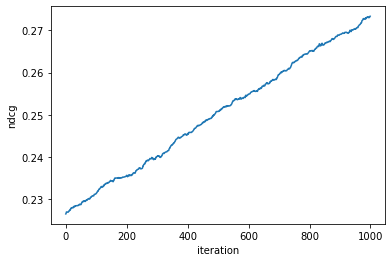

In [127]:
plt.plot(range(1000), classical_ndcg5)
plt.ylabel("ndcg")
plt.xlabel("iteration")

In [73]:
# fed
fed1=[]
fed5=[]
for i in range(1000):
    fed1.append((ndcg1[i]+ndcg1_2[i])/2)
    fed5.append((ndcg5[i]+ndcg1_2[i])/2)

In [82]:
# federated model
fed1, fed5 = training_loop2(
    n_epochs = 10,
    optimizer = torch.optim.SGD(combined_model.parameters(),lr = 0.01),
    model = combined_model,
    train = fold3
    )

epoch:1, loss:0.3379371762275696, ndcg@1:0.1779744178056717, ndcg@5:0.21060408651828766
epoch:2, loss:0.33793699741363525, ndcg@1:0.1779744178056717, ndcg@5:0.21036727726459503
epoch:3, loss:0.3379366993904114, ndcg@1:0.1779744178056717, ndcg@5:0.21041111648082733
epoch:4, loss:0.3379364311695099, ndcg@1:0.1779744178056717, ndcg@5:0.2103259265422821
epoch:5, loss:0.3379361927509308, ndcg@1:0.1779744178056717, ndcg@5:0.2103259265422821
epoch:6, loss:0.33793601393699646, ndcg@1:0.1779744178056717, ndcg@5:0.21039524674415588
epoch:7, loss:0.33793574571609497, ndcg@1:0.1779744178056717, ndcg@5:0.2104824185371399
epoch:8, loss:0.3379356265068054, ndcg@1:0.1779744178056717, ndcg@5:0.2110026478767395
epoch:9, loss:0.3379354476928711, ndcg@1:0.1779744178056717, ndcg@5:0.2110026478767395
epoch:10, loss:0.33793511986732483, ndcg@1:0.1779744178056717, ndcg@5:0.2105785310268402


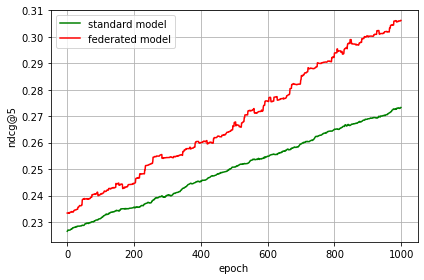

In [128]:
"""複数のグラフを重ねて描画するプログラム"""
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

t = range(1000)
y1 = classical_ndcg5
y2 = fed5

c1,c2 = "green","red"     # 各プロットの色
l1,l2 = "standard model","federated model"   # 各ラベル

ax.set_xlabel('epoch')  # x軸ラベル
ax.set_ylabel('ndcg@5')  # y軸ラベル
#ax.set_title(r'$\sin(x)$ and $\cos(x)$') # グラフタイトル
# ax.set_aspect('equal') # スケールを揃える
ax.grid()            # 罫線
#ax.set_xlim([-10, 10]) # x方向の描画範囲を指定
#ax.set_ylim([0, 1])    # y方向の描画範囲を指定
ax.plot(t, y1, color=c1, label=l1)
ax.plot(t, y2, color=c2, label=l2)
#ax.plot(t, y3, color=c3, label=l3)
#ax.plot(t, y4, color=c4, label=l4)
ax.legend(loc=0)    # 凡例
fig.tight_layout()  # レイアウトの設定
plt.savefig('fed4_ranknet.png') # 画像の保存
plt.show()

In [129]:
#fed
print(testing(combined_model, s5, 1))
print(testing(combined_model, s5, 5))

tensor(0.3284)
tensor(0.3458)


In [131]:
# classic
print(testing(classical_model, s5, 1))
print(testing(classical_model, s5, 5))

tensor(0.2579)
tensor(0.2892)


---

In [ ]:
data_list=[fold1,fold2]

In [7]:
def training_loop(n_epochs,optimizer,model,data_list):
    count = 0
    best_ndcg = 0
    
    while count < len(data_list):
        # 最初の3つをtrainに
        train = data_list[0]+data_list[1]+data_list[2]
        # 1つをvalidationに
        val = data_list[3]
        # 最後をtestに
        test = data_list[4]
        
        # モデルの訓練
        for epoch in range(1, n_epochs + 1):
        
            # クエリごとの訓練
            batch_loss = 0
            batch_ndcg = 0
            for _,batch_ranking,label in train:
                batch_loss += model.forward(batch_ranking=batch_ranking, label=label)
                #print(compute_ndcg(batch_ranking,label,5))
                batch_ndcg += compute_ndcg(batch_ranking,label,5)
                    
            fold_loss_mean = batch_loss / (len(data_list[0])+len(data_list[1])+len(data_list[2]))
            fold_ndcg_mean = batch_ndcg / (len(data_list[0])+len(data_list[1])+len(data_list[2]))
            
            if epoch ==1 or epoch%10==0:
                print('epoch:{0}, loss:{1}, ndcg:{2}'.format(epoch, fold_loss_mean, fold_ndcg_mean))
            
            # パラメータ選択
            val_loss = 0
            val_ndcg = 0
            for _,batch_ranking,label in val:
                val_loss += model.forward(batch_ranking=batch_ranking, label=label)
                val_ndcg += compute_ndcg(batch_ranking,label,5)
                
            val_loss_mean = val_loss / len(val)
            val_ndcg_mean = val_ndcg / len(val)    
                
            if val_ndcg_mean > best_ndcg:
                best_ndcg = val_ndcg_mean
            
                # 訓練したモデルの保存
                torch.save(model.state_dict(), 'weight.pth')
            
            optimizer.zero_grad()
            fold_loss_mean.backward()
            optimizer.step()
            
        # パラメータの読み込み
        param = torch.load('weight.pth')
        model.load_state_dict(param)
        
        #test
        test_ndcg = testing(test)
        
        print('test:{0}'.format(test_ndcg))
        
        #　右にひとつシフト ([1,2,3,4,5] -> [5,1,2,3,4]となる)
        data_list.insert(0,data_list.pop())
        
#         if epoch%10==0:
#             print("epoch: ", epoch, "loss: ", epoch_loss, "ndcg: ", epoch_ndcg)
        count += 1

In [8]:
data_list = [fold1,fold2,fold3,fold4,fold5]

In [17]:
# クラスのインスタンス化
model = RankNet(layers)

In [10]:
training_loop(
    n_epochs = 100,
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01),
    model = model,
    data_list = data_list,
    )

epoch:1, loss:0.33804816007614136, ndcg:0.2129535973072052
epoch:10, loss:0.3380464017391205, ndcg:0.21400970220565796
epoch:20, loss:0.33804401755332947, ndcg:0.21507927775382996
epoch:30, loss:0.3380418121814728, ndcg:0.21627427637577057
epoch:40, loss:0.33803996443748474, ndcg:0.218105748295784
epoch:50, loss:0.33803796768188477, ndcg:0.21888558566570282
epoch:60, loss:0.33803579211235046, ndcg:0.2204192578792572
epoch:70, loss:0.3380337357521057, ndcg:0.22214770317077637
epoch:80, loss:0.3380317687988281, ndcg:0.2235986590385437
epoch:90, loss:0.338029682636261, ndcg:0.224581778049469
epoch:100, loss:0.33802759647369385, ndcg:0.225375235080719
test:0.2294071763753891
epoch:1, loss:0.33805733919143677, ndcg:0.23191629350185394
epoch:10, loss:0.3380555808544159, ndcg:0.2341095507144928
epoch:20, loss:0.3380531668663025, ndcg:0.2361796349287033
epoch:30, loss:0.33805134892463684, ndcg:0.23738986253738403
epoch:40, loss:0.33804914355278015, ndcg:0.23919181525707245
epoch:50, loss:0.338